## 使用CNN对猫和狗的图像进行分类
本例使用到了图像增强(Image Augmentation)和Dropout技术防止过拟合
### 样例
尺寸不同的RGB三通道彩色图片，分为猫和狗两类
### 标签
* 0: Cats
* 1: Dogs

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 导入数据
### 下载数据
本例使用的数据集是Kaggle的**Dogs vs. Cats**数据集的子数据集(Provided by Microsoft Research)。原数据集共300万条数据，其中可用的有2万5千条，取其中3000条作为本例的数据集：
* **训练集(Training Set)**：2000条
    * **Cats**：1000条
    * **Dogs**：1000条
* **测试集/验证集(Test Set/Validation Set)**：1000条
    * **Cats**：500条
    * **Dogs**：500条

首先将数据下载到本地，并解压到同文件夹中data路径下。[数据下载链接](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)

In [2]:
base_dir = os.path.join('data', 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### 获取各数据集各种样本的样本数

In [3]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [4]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 设置BATCH_SIZE以及IMG_SHAPE
* **BATCH_SIZE**：一个Batch中图片的数量
* **IMG_SHAPE**：首先需要将尺寸不同的图片处理成尺寸相同的图片，这里的``IMG_SHAPE``即处理后的图片高和宽的像素数

In [5]:
BATCH_SIZE = 128  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

## 数据增强
Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass  different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

关于``tf.keras.preprocessing.image.ImageDataGenerator``类的简单介绍见[Dogs and Cats 1.0中**图像数据预处理**部分](./Dogs%20and%20Cats%201.0.ipynb#图像数据预处理)。

**数据增强不会是使每一``epoch``中训练数据集的数据增加，而是会在每一``epoch``中使每张图片进行随机变换，保证模型在训练的过程中不会遇见相同的图片两次。**

首先定义一个展示图片的方法，以观察数据增强的效果

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### 水平翻转图片
对图片随机进行水平翻转。通过在``tf.keras.preprocessing.image.ImageDataGenerator``类中传入``horizontal_flip=True``参数实现。

In [7]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


查看相同图片5次，每次都会随机使用数据增强方法使图像改变。

* ``train_data_gen[0]``得到第一个``Batch``的所有图片以及对应的标签组成的``tuple``
* ``train_data_gen[0][0]``即第一个``Batch``的所有图片
* ``train_data_gen[0][0][0]``即第一个``Batch``的第一张图片。

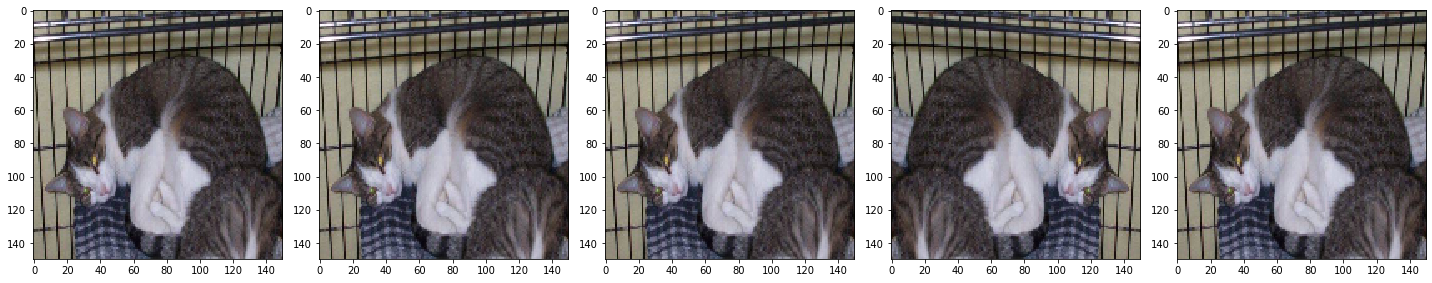

In [8]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 旋转图片
设置``tf.keras.preprocessing.image.ImageDataGenerator``类的``rotation_range``参数，使其随机旋转对应度数（顺时针或逆时针，且旋转度数不超过传入值）。

In [9]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


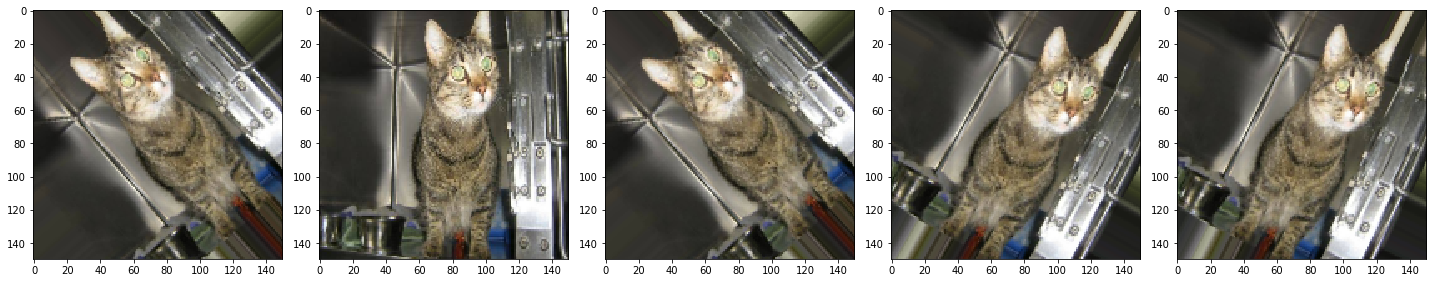

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 图片缩放
设置``tf.keras.preprocessing.image.ImageDataGenerator``类的``zoom_range``参数，使其随机缩放并设置缩放范围。

参数设置见[同时使用多种图像增强方法](#同时使用多种图像增强方法)

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


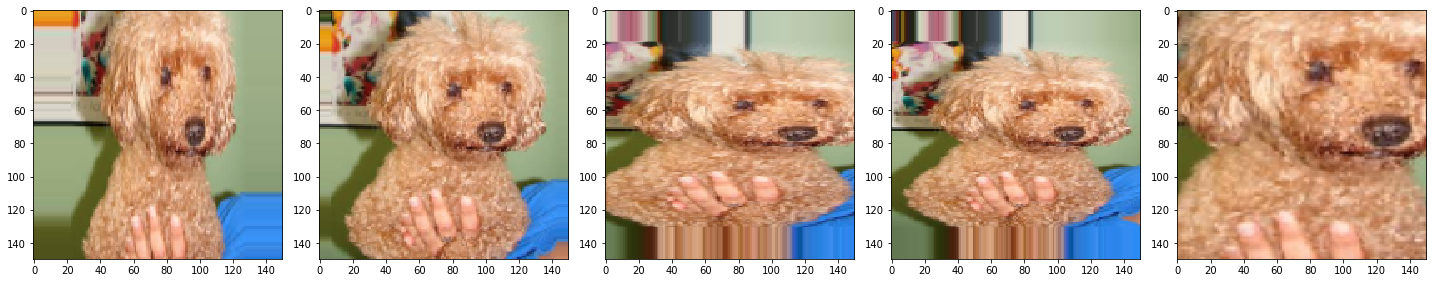

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 同时使用多种图像增强方法
此处用到的不同参数对应的方法分别为：
* **rotation_range**: Int. Degree range for random rotations.
* **width_shift_range**: 在水平方向随机进行平移。传入参数类型为Float, 1-D array-like or int
    * **float**: fraction of total width, if < 1, or pixels if >= 1.
    * **1-D array-like**: random elements from the array.
    * **int**: integer number of pixels from interval ``(-width_shift_range, +width_shift_range)``
    * With ``width_shift_range=2`` possible values are integers ``[-1, 0, +1]``, same as with width_shift_range=``[-1, 0, +1]``, while with width_shift_range=1.0 possible values are floats in the interval ``[-1.0, +1.0)``.
* **height_shift_range**：与**width_shift_range**类似
* **shear_range**: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees).
* **zoom_range**：Float or ``[lower, upper]``. Range for random zoom. If a float, ``[lower, upper] = [1-zoom_range, 1+zoom_range]``.
* **horizontal_flip**: Boolean. Randomly flip inputs horizontally.
* **fill_mode**: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:
    * **'constant'**: kkkkkkkk|abcd|kkkkkkkk (cval=k)
    * **'nearest'**: aaaaaaaa|abcd|dddddddd
    * **'reflect'**: abcddcba|abcd|dcbaabcd
    * **'wrap'**: abcdabcd|abcd|abcdabcd
    
其他参数详见[API中说明](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used_in_the_tutorials)。

In [13]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


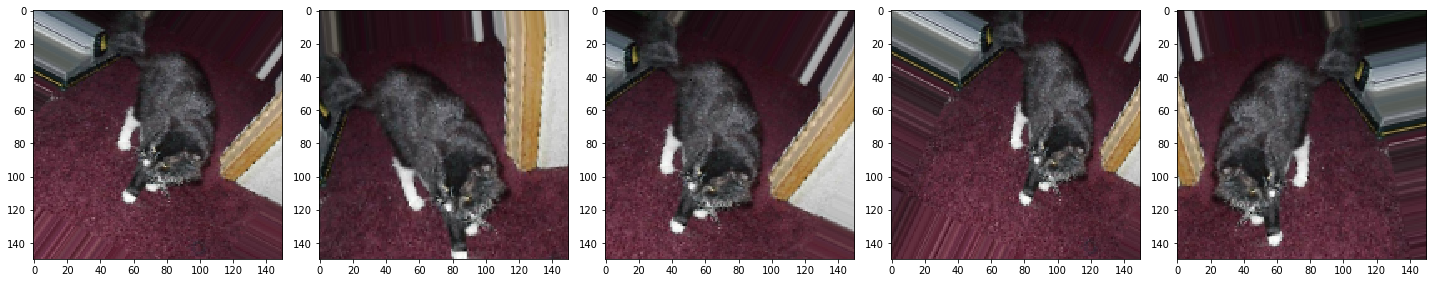

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 创建验证集生成器
通常只对训练集中的图片做数据增强，因此验证集中的图片只做``rescale``操作。

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=validation_dir, 
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## 构建模型
此网络包含4组卷积层，以及一个``Flatten``层和两个全连接层(Dense)。输出层包含两个神经元，使用**softmax**激活函数（也可以将输出层设置为只有一个神经元，使用**sigmoid**激活函数）。

在``Flatten``层前使用``Dropout``，增强模型的泛化能力，并设置将神经元丢弃的概率。

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
#     tf.keras.layers.Dense(1, activation='sigmoid')
])

## 编译模型
可以使用多种损失函数以及``metrics``对模型进行编译（另一种方法见注释掉的代码）。

``tf.keras.optimizers.Adam()``的``learning_rate``这里使用默认值0.001。若使用0.01则会训练出一枚质地均匀的硬币。。。

In [17]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
# model.compile(loss=tf.keras.losses.binary_crossentropy,
#              optimizer=tf.keras.optimizers.Adam(),
#              metrics=[tf.keras.metrics.binary_accuracy])

### 使用``model.summary()``方法查看网络中每一层以及每层的参数数量

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 训练模型
这里使用``model.fit_generator``方法训练模型（也可使用``model.fit``方法）。此方法的具体使用详见[API中的描述](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/Sequential#fit_generator)。

同时在每一``epoch``训练结束后将当前模型在测试集上进行测试，观察当前模型在测试集上分类的准确率。

In [19]:
EPOCHS = 100
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
                              verbose=1)

Epoch 1/100


W0725 11:38:30.985030  1308 deprecation.py:323] From C:\Users\arsener\PycharmProjects\tensorflow2.0beta\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


16/16 [==============================] - 134s 8s/step - loss: 0.7584 - accuracy: 0.5015 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 135s 8s/step - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6906 - val_accuracy: 0.6270
Epoch 3/100
16/16 [==============================] - 140s 9s/step - loss: 0.6877 - accuracy: 0.5700 - val_loss: 0.6689 - val_accuracy: 0.6310
Epoch 4/100
16/16 [==============================] - 134s 8s/step - loss: 0.6671 - accuracy: 0.5865 - val_loss: 0.6375 - val_accuracy: 0.6420
Epoch 5/100
16/16 [==============================] - 134s 8s/step - loss: 0.6727 - accuracy: 0.5665 - val_loss: 0.6811 - val_accuracy: 0.5300
Epoch 6/100
16/16 [==============================] - 130s 8s/step - loss: 0.6630 - accuracy: 0.5990 - val_loss: 0.6296 - val_accuracy: 0.6220
Epoch 7/100
16/16 [==============================] - 124s 8s/step - loss: 0.6506 - accuracy: 0.6110 - val_loss: 0.6582 - val_accuracy: 0.5940
Epoch 8/100
16/16 

16/16 [==============================] - 104s 6s/step - loss: 0.4348 - accuracy: 0.8000 - val_loss: 0.4729 - val_accuracy: 0.7720
Epoch 59/100
16/16 [==============================] - 103s 6s/step - loss: 0.4377 - accuracy: 0.7975 - val_loss: 0.4426 - val_accuracy: 0.8020
Epoch 60/100
16/16 [==============================] - 102s 6s/step - loss: 0.4321 - accuracy: 0.8030 - val_loss: 0.4427 - val_accuracy: 0.8050
Epoch 61/100
16/16 [==============================] - 102s 6s/step - loss: 0.4200 - accuracy: 0.8040 - val_loss: 0.4037 - val_accuracy: 0.8130
Epoch 62/100
16/16 [==============================] - 103s 6s/step - loss: 0.4050 - accuracy: 0.8275 - val_loss: 0.4495 - val_accuracy: 0.7890
Epoch 63/100
16/16 [==============================] - 103s 6s/step - loss: 0.3963 - accuracy: 0.8155 - val_loss: 0.4639 - val_accuracy: 0.7700
Epoch 64/100
16/16 [==============================] - 103s 6s/step - loss: 0.4245 - accuracy: 0.8000 - val_loss: 0.4748 - val_accuracy: 0.7770
Epoch 65/100

## 可视化训练结果
将模型在训练集以及测试集上分别得到的不同``epoch``对应的``loss``以及准确率进行可视化。

可以看到模型的**过拟合**情况得到了较大的改善，在``epoch``大约为70的时候产生了guonihe。

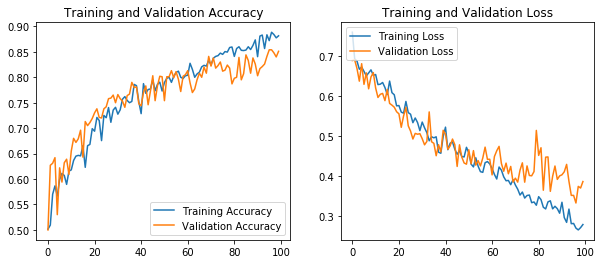

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()